# [Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic)

## Data

- PassengerId - 각 승객에 대한 고유 ID
  - gggg_pp: gggg는 group, pp는 group에 소속된 사람 수
  - 같은 group에 속한 사람들은 가족일 수도 있고, 아닐 수도 있음
- HomePlanet - 출발 행성(거주지)
- CryoSleep - 취침 방식 여부
- Cabin - 객실 종류 및 번호(port:좌현, starboard: 우현)
- Destination - 목적지
- Age - 승객의 나이
- VIP - 승객의 VIP 서비스 유무
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - 승객이 해당 서비스에 대한 지불한 금액
- Name - 이름
  - 같은 그룹이면서, 성이 같으면 ?? 가족일 확률이 높음
- Transported - 도착여부

# Import Library

In [1]:
import os
import datetime

# 데이터 분석
import numpy as np
import pandas as pd
from scipy import stats

# 데이터 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

plt.ion()
# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')



# 데이터 분리
from sklearn.model_selection import train_test_split


# warning
import warnings
warnings.filterwarnings('ignore')

# Global Variables

In [2]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [3]:
import easydict
import json
args = easydict.EasyDict()

# path
args.default_path = '/content/data/MyDrive/google_lecture/05. machine learning/Projects/kaggle/spaceship_titanic/data/'
args.train_path = args.default_path+'train.csv'
args.test_path = args.default_path+'test.csv'
args.submission_path = args.default_path+'sampleSubmission.csv'

args.SEED = 42

# Load Data

In [4]:
train = pd.read_csv(args.train_path)
test = pd.read_csv(args.test_path)

train.shape, test.shape

((8693, 14), (4277, 13))

In [5]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


# Target
- 5:5 비율의 데이터임

In [15]:
train_size = train.shape[0]
df_target = pd.DataFrame(train['Transported'].value_counts())
df_target['Target distribution'] = df_target['Transported'].map(lambda x: round(x/train_size, 3))

df_target

,Transported,Target distribution
True,4378,0.504
False,4315,0.496


# Missing Values
- 2%정도의 결측치 존재
- 2개 이상 결측치가 있는 passenger는 많지 않음

In [68]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(3267, 1117)

In [69]:
(train.isnull().sum() / train.shape[0]).round(4).sort_values(ascending=False) # 각 걸럼별 결측치 비율

CryoSleep             0.0250
ShoppingMall          0.0239
log1p_ShoppingMall    0.0239
VIP                   0.0234
HomePlanet            0.0231
Name                  0.0230
Cabin                 0.0229
VRDeck                0.0216
log1p_VRDeck          0.0216
FoodCourt             0.0211
Spa                   0.0211
log1p_FoodCourt       0.0211
log1p_Spa             0.0211
Destination           0.0209
RoomService           0.0208
log1p_RoomService     0.0208
Age                   0.0206
Transported           0.0000
PassengerId           0.0000
dtype: float64

In [70]:
(test.isnull().sum() / test.shape[0]).round(4).sort_values(ascending=False) # 각 걸럼별 결측치 비율

FoodCourt       0.0248
Spa             0.0236
Cabin           0.0234
ShoppingMall    0.0229
Name            0.0220
CryoSleep       0.0217
VIP             0.0217
Destination     0.0215
Age             0.0213
HomePlanet      0.0203
RoomService     0.0192
VRDeck          0.0187
PassengerId     0.0000
dtype: float64

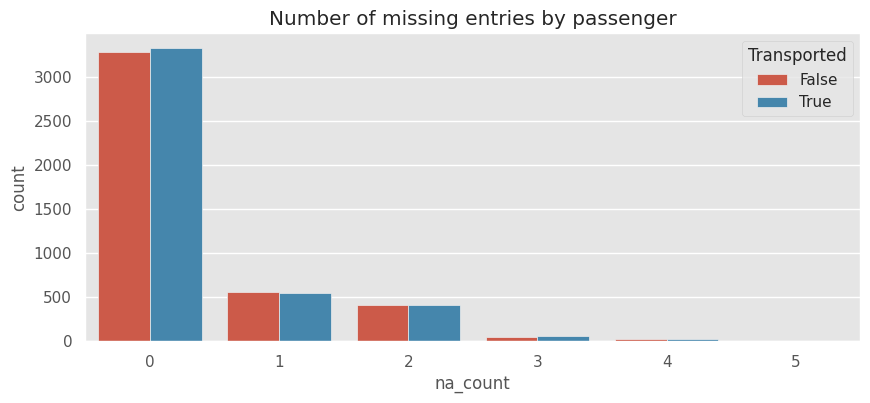

In [77]:
# Countplot of number of missing values by passenger
train['na_count']=train.isna().sum(axis=1)
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='na_count', hue='Transported')
plt.title('Number of missing entries by passenger')
train.drop('na_count', axis=1, inplace=True)

In [106]:
# Columns with missing values
na_cols=train.columns[train.isna().any()].tolist()

# Missing values summary
mv=pd.DataFrame(train[na_cols].isna().sum(), columns=['Number_missing'])
mv['Percentage_missing']=np.round(100*mv['Number_missing']/len(train),2)
mv

,Number_missing,Percentage_missing
HomePlanet,201,2.31
CryoSleep,217,2.50
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39
Spa,183,2.11
VRDeck,188,2.16


Text(0.5, 1.0, 'Heatmap of missing values')

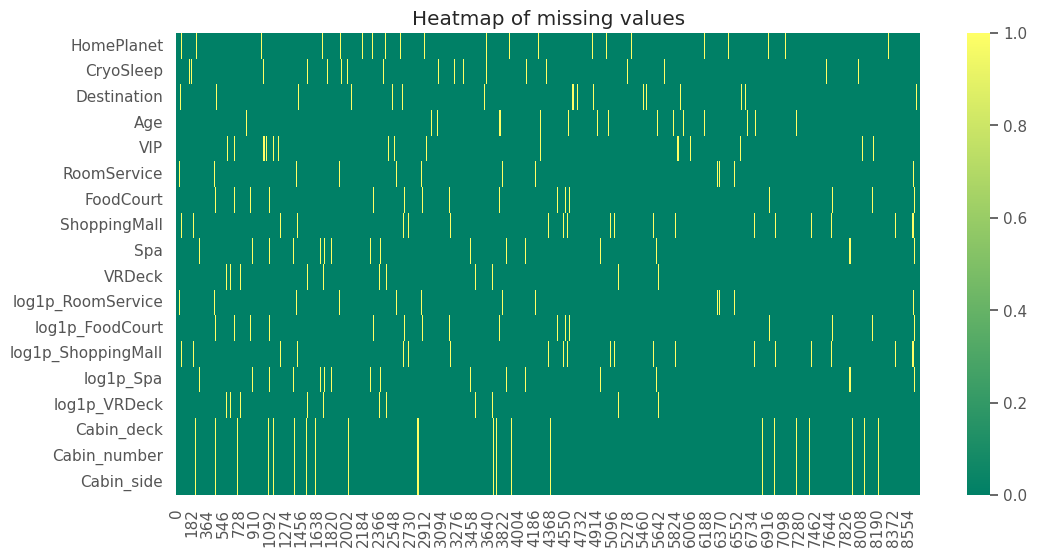

In [107]:
# Heatmap of missing values
plt.figure(figsize=(12,6))
sns.heatmap(train[na_cols].isna().T, cmap='summer')
plt.title('Heatmap of missing values')

# Continuous

## Age
- 0-18은 True가 높음
- 19-27은 False가 높음
- 28부터는 비슷비슷함

Text(0.5, 0, 'Age (years)')

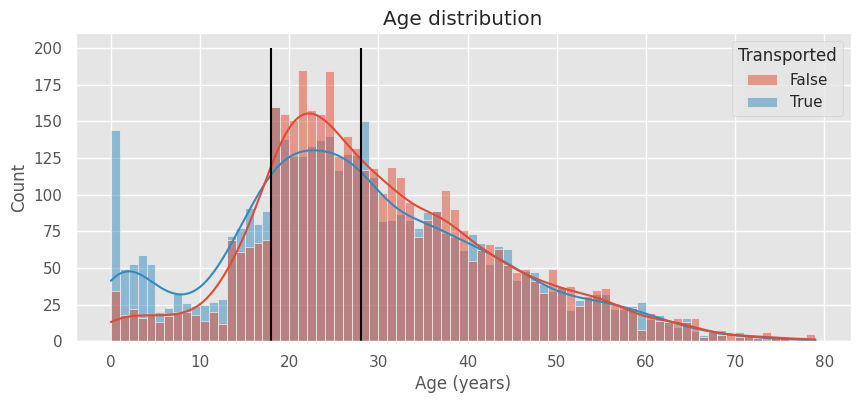

In [99]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

plt.vlines(18, ymin=0, ymax=200, color='black')
plt.vlines(28, ymin=0, ymax=200, color='black')

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

In [59]:
df_age = pd.DataFrame(train.groupby(['Age'])['Transported'].value_counts()).rename(columns={'Transported':'counts'}).reset_index()
df_age_pivot = pd.pivot_table(df_age, index='Age', columns='Transported', values='counts')
df_age_pivot['different'] = df_age_pivot[True] - df_age_pivot[False]

print(df_age_pivot.shape)
df_age_pivot.head(3)

(80, 3)


Transported,False,True,different
Age,,,
0.0,34.0,144.0,110.0
1.0,18.0,49.0,31.0
2.0,22.0,53.0,31.0


In [53]:
df_age_pivot[0:18]

Transported,False,True,different
Age,,,
0.0,34.0,144.0,110.0
1.0,18.0,49.0,31.0
2.0,22.0,53.0,31.0
3.0,16.0,59.0,43.0
4.0,18.0,53.0,35.0
5.0,13.0,20.0,7.0
6.0,17.0,23.0,6.0
7.0,20.0,32.0,12.0
8.0,20.0,26.0,6.0


In [97]:
df_age_pivot[19:27]

Transported,False,True,different
Age,,,
19.0,155.0,138.0,-17.0
20.0,151.0,126.0,-25.0
21.0,185.0,126.0,-59.0
22.0,158.0,133.0,-25.0
23.0,155.0,137.0,-18.0
24.0,184.0,140.0,-44.0
25.0,126.0,117.0,-9.0
26.0,140.0,128.0,-12.0
27.0,132.0,127.0,-5.0


## Expenditure features
> RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

- 대부분의 사람들은 돈을 쓰지 않았음
- 왜도가 심함
  - log1p 사용필요
- outlier가 많지 않음
- 돈을 덜 쓴 사람들이 False가 많음
- luxury
  - RoomService, Spa, VRDeck
  - False 데이터인 분들의 소비가 더 높음
- essential
  - FoodCourt, ShoppingMall
  - True 데이터인 분들의 소비가 더 높음

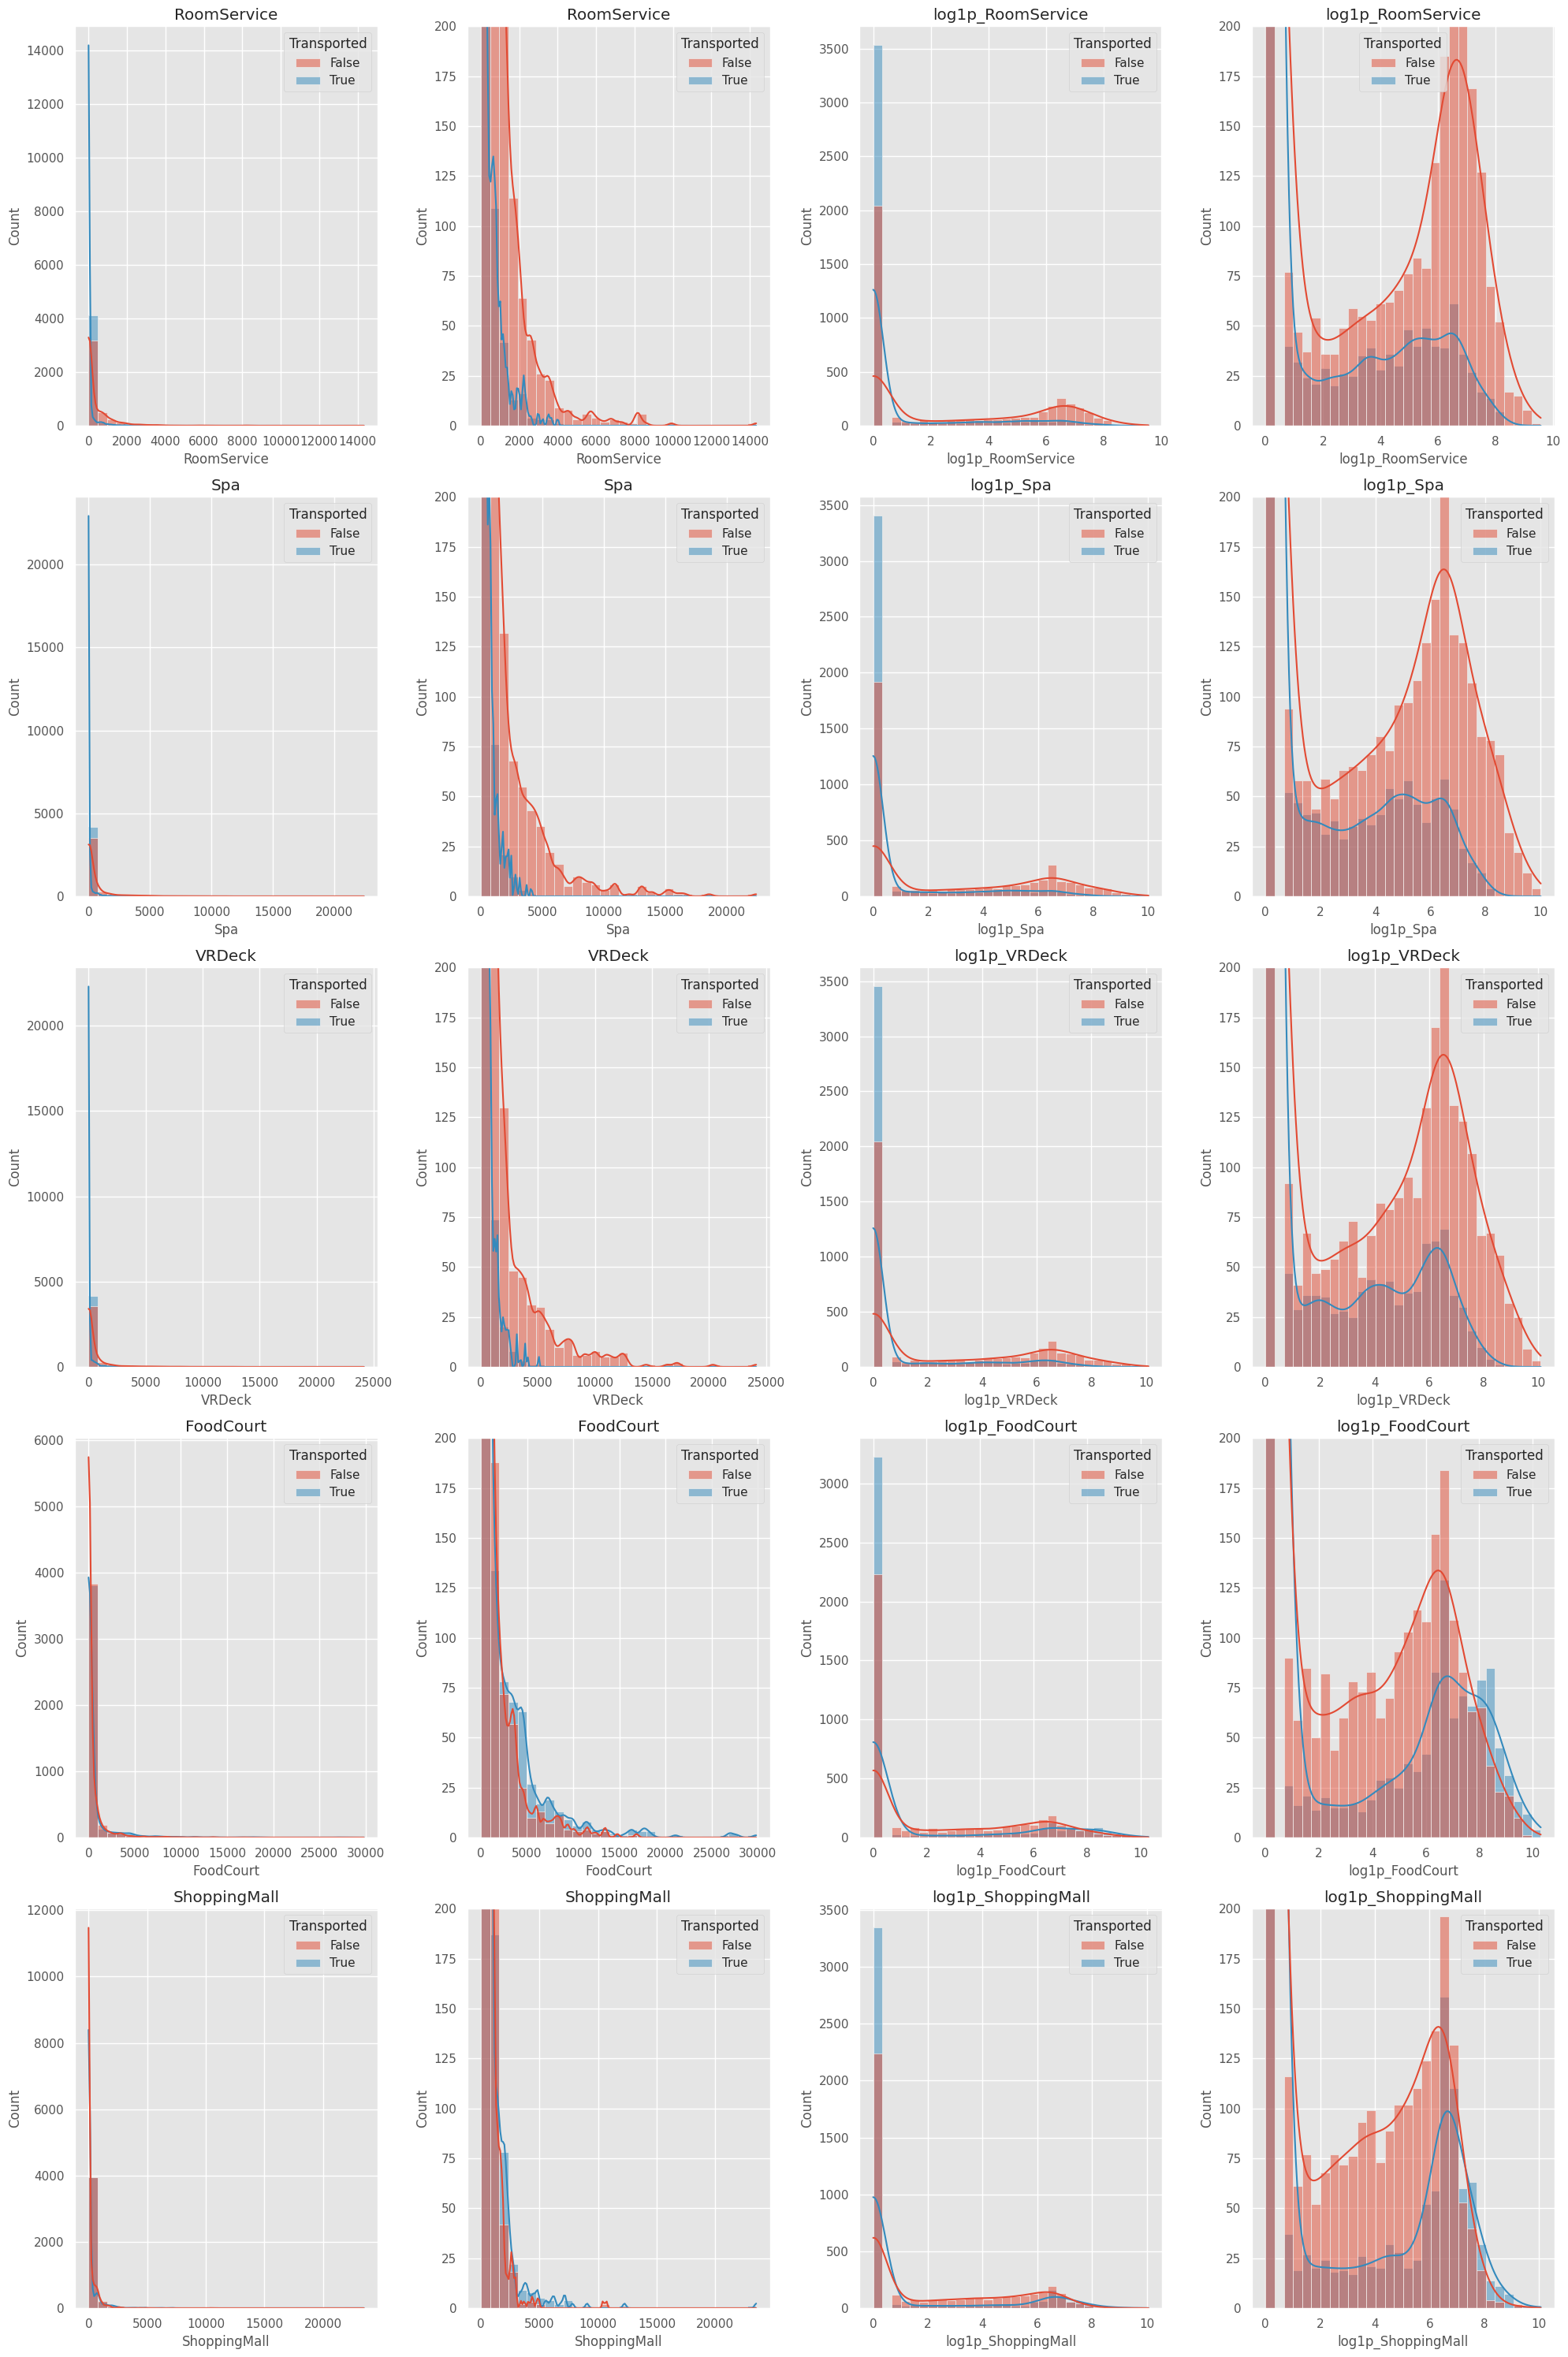

In [67]:
# Expenditure features
exp_feats=['RoomService', 'Spa', 'VRDeck', 'FoodCourt', 'ShoppingMall']

# Plot expenditure features
fig=plt.figure(figsize=(20,30))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,4,4*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    ax.set_title(var_name)

    # Right plot (truncated)
    ax=fig.add_subplot(5,4,4*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,200])
    ax.set_title(var_name)

    ax=fig.add_subplot(5,4,4*i+3)
    new_col_nm = f'log1p_{var_name}'
    train[new_col_nm] = train[var_name].map(lambda x: np.log1p(x))
    sns.histplot(data=train, x=new_col_nm, axes=ax, bins=30, kde=True, hue='Transported')
    # plt.ylim([0,100])
    ax.set_title(new_col_nm)

    ax=fig.add_subplot(5,4,4*i+4)
    sns.histplot(data=train, x=new_col_nm, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,200])
    ax.set_title(new_col_nm)

fig.tight_layout()  # Improves appearance a bit
plt.show()

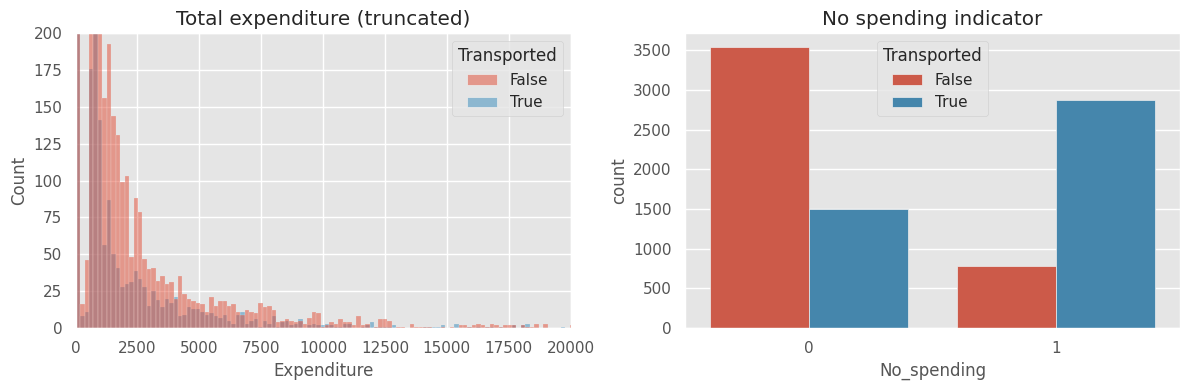

In [81]:
# New features - training set
train['Expenditure']=train[exp_feats].sum(axis=1)
train['No_spending']=(train['Expenditure']==0).astype(int)

# New features - test set
test['Expenditure']=test[exp_feats].sum(axis=1)
test['No_spending']=(test['Expenditure']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Expenditure', hue='Transported', bins=200)
plt.title('Total expenditure (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

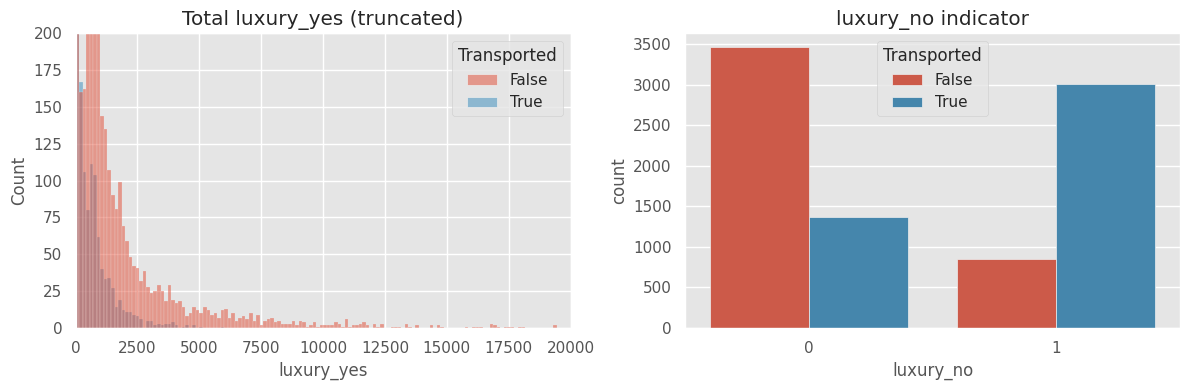

In [82]:
# New features - training set
luxury_cols = ['RoomService', 'Spa', 'VRDeck']
train['luxury_yes']=train[luxury_cols].sum(axis=1)
train['luxury_no']=(train['luxury_yes']==0).astype(int)

# New features - test set
test['luxury_yes']=test[luxury_cols].sum(axis=1)
test['luxury_no']=(test['luxury_yes']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='luxury_yes', hue='Transported', bins=200)
plt.title('Total luxury_yes (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train, x='luxury_no', hue='Transported')
plt.title('luxury_no indicator')
fig.tight_layout()

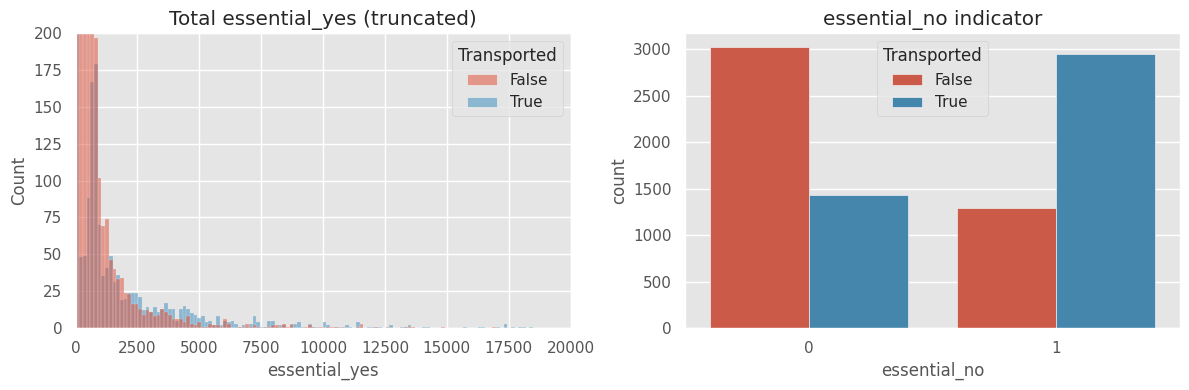

In [83]:
# New features - training set
essential_cols = ['FoodCourt', 'ShoppingMall']
train['essential_yes']=train[essential_cols].sum(axis=1)
train['essential_no']=(train['essential_yes']==0).astype(int)

# New features - test set
test['essential_yes']=test[essential_cols].sum(axis=1)
test['essential_no']=(test['essential_yes']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='essential_yes', hue='Transported', bins=200)
plt.title('Total essential_yes (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train, x='essential_no', hue='Transported')
plt.title('essential_no indicator')
fig.tight_layout()

# Categorical

- VIP는 예측을 하는데 도움이 되지 않을 것 같음
- CryoSleep은 유용한 변수임

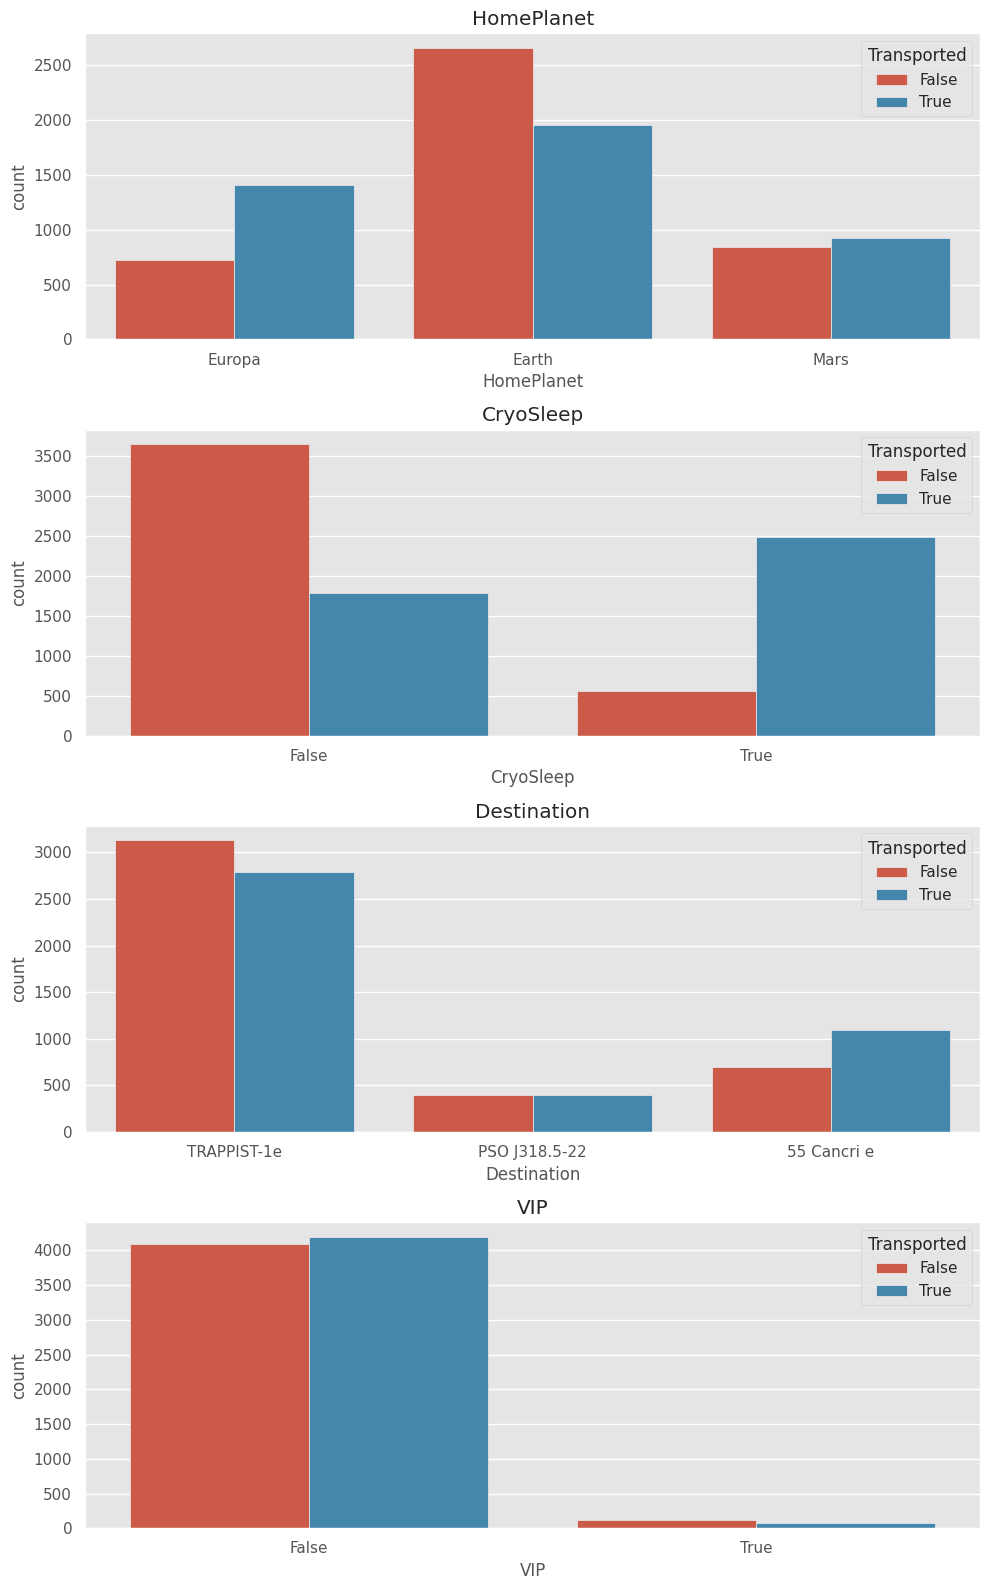

In [9]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

# Qualitative

- Notes:
  - PassengerId takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
  - Cabin takes the form deck/num/side, where side can be either P for Port or S for Starboard.

- PassengerId
  - id_number within the group
- Cabin
  - deck/num/side
- Name
  - 성을 이용하여 가족 구분 가능

In [10]:
# Qualitative features
qual_feats=['PassengerId', 'Cabin' ,'Name']

# Preview qualitative features
train[qual_feats].head()

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines


## PassengerId

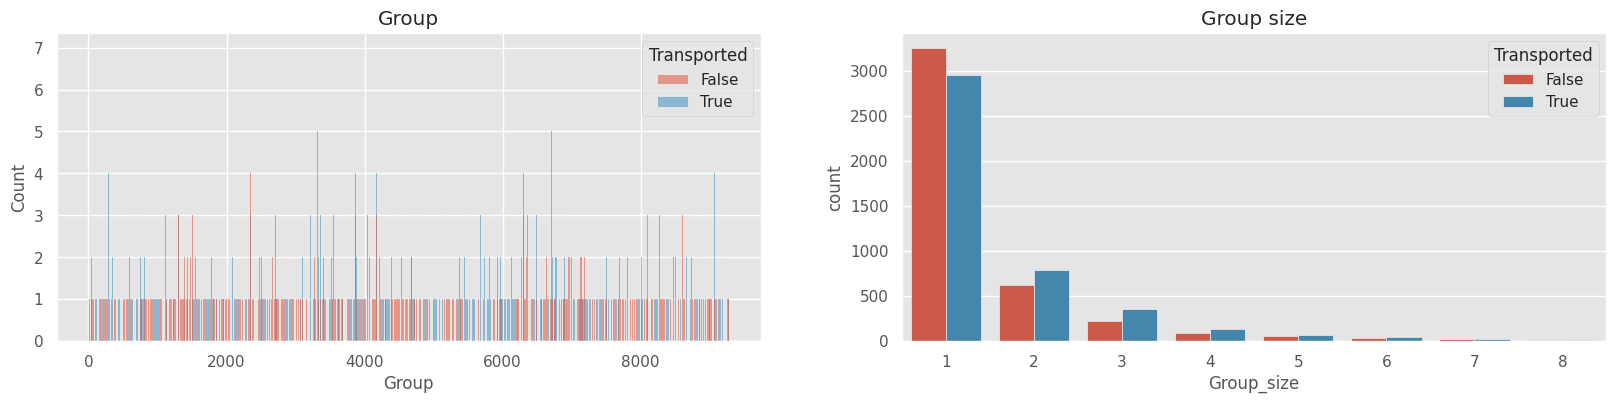

In [86]:
# New feature - Group
train['Group'] = train['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
test['Group'] = test['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

# New feature - Group size
train['Group_size'] = train['PassengerId'].apply(lambda x: x.split('_')[1]).astype(int)
test['Group_size'] = test['PassengerId'].apply(lambda x: x.split('_')[1]).astype(int)

# Plot distribution of new features
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
sns.histplot(data=train, x='Group', hue='Transported', binwidth=1)
plt.title('Group')

plt.subplot(1,2,2)
sns.countplot(data=train, x='Group_size', hue='Transported')
plt.title('Group size')
fig.tight_layout()

Text(0.5, 1.0, 'Passenger travelling solo or not')

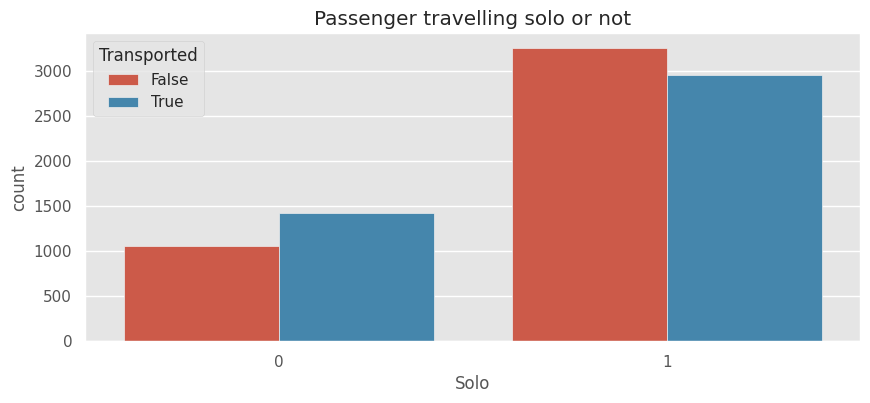

In [88]:
# New feature
train['Solo']=(train['Group_size']==1).astype(int)
test['Solo']=(test['Group_size']==1).astype(int)

# New feature distribution
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='Solo', hue='Transported')
plt.title('Passenger travelling solo or not')
# plt.ylim([0,3000])

## Name

In [100]:
# Replace NaN's with outliers for now (so we can split feature)
train['Name'].fillna('Unknown Unknown', inplace=True)
test['Name'].fillna('Unknown Unknown', inplace=True)

# New feature - Surname
train['Surname']=train['Name'].str.split().str[-1]
test['Surname']=test['Name'].str.split().str[-1]


In [103]:
train[['Name', 'Surname']].head()

,Name,Surname
0,Maham Ofracculy,Ofracculy
1,Juanna Vines,Vines
2,Altark Susent,Susent
3,Solam Susent,Susent
4,Willy Santantines,Santantines


In [104]:
train['Surname'].value_counts()

Unknown       200
Casonston      18
Oneiles        16
Domington      15
Litthews       15
             ... 
Covale          1
Dun             1
Witalnerod      1
Deryplinet      1
Sionerorly      1
Name: Surname, Length: 2218, dtype: int64

## Cabin

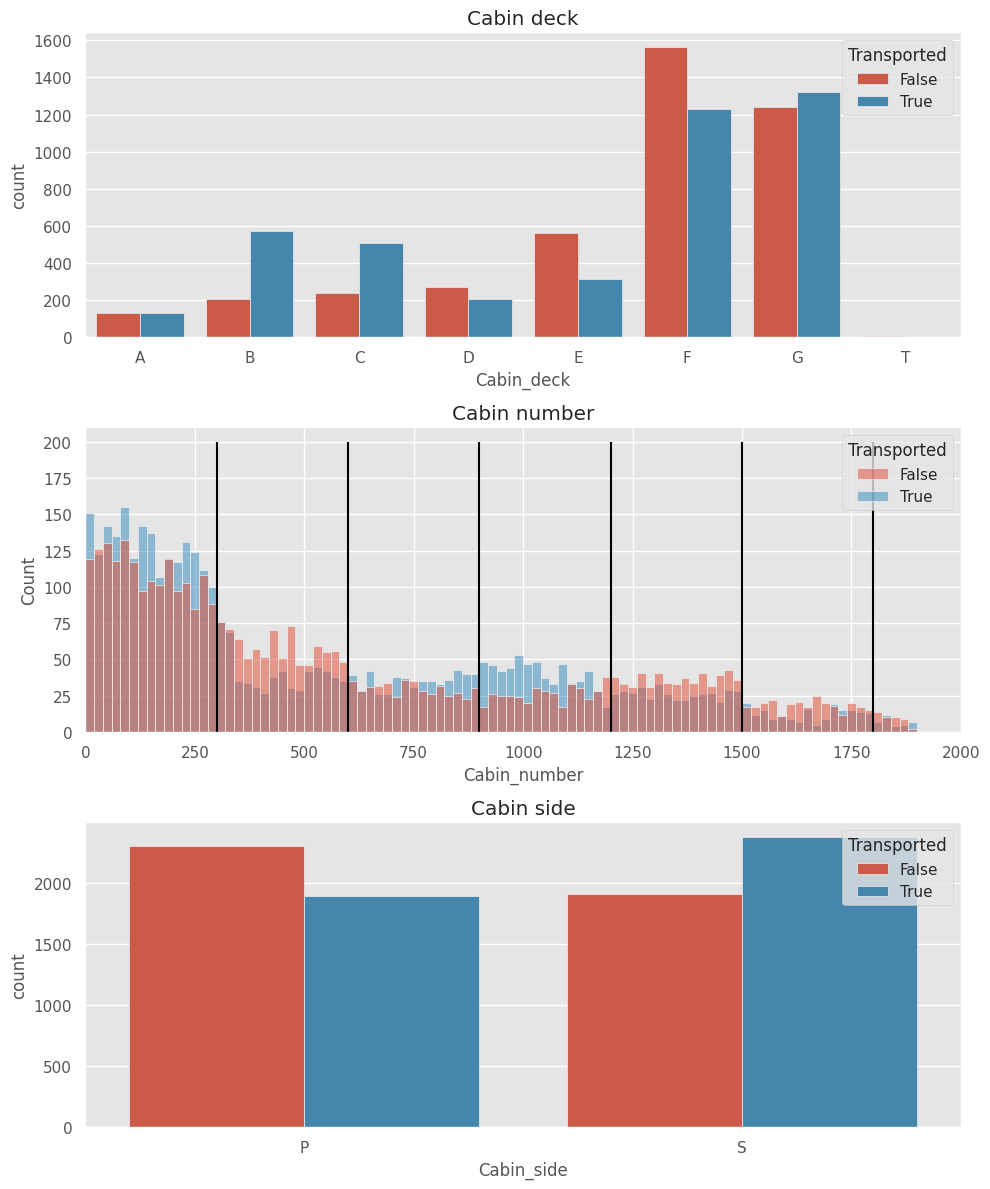

In [89]:
# Replace NaN's with outliers for now (so we can split feature)
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

# New features - training set
train['Cabin_deck'] = train['Cabin'].apply(lambda x: x.split('/')[0])
train['Cabin_number'] = train['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x: x.split('/')[2])

# New features - test set
test['Cabin_deck'] = test['Cabin'].apply(lambda x: x.split('/')[0])
test['Cabin_number'] = test['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x: x.split('/')[2])

# Put Nan's back in (we will fill these later)
train.loc[train['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
train.loc[train['Cabin_number']==9999, 'Cabin_number']=np.nan
train.loc[train['Cabin_side']=='Z', 'Cabin_side']=np.nan
test.loc[test['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
test.loc[test['Cabin_number']==9999, 'Cabin_number']=np.nan
test.loc[test['Cabin_side']=='Z', 'Cabin_side']=np.nan

# Drop Cabin (we don't need it anymore)
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

# Plot distribution of new features
fig=plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin deck')

plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_number', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Cabin number')
plt.xlim([0,2000])

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
plt.title('Cabin side')
fig.tight_layout()